In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini")


In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

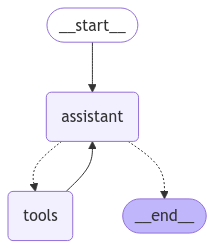

In [11]:
from IPython.display import display, Image
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def assistant(state: MessagesState) -> MessagesState:

    system_message = SystemMessage(content = "You are a helpful assistant that can perform arithemetic operations on a set of inputs.")

    return {"messages" : [llm_with_tools.invoke([system_message] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile(checkpointer = memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [19]:
initial_input = {"messages" : [HumanMessage(content = "Multiply 2 and 3")]}
thread = {"configurable" : {"thread_id" : "11"}}

for event in graph.stream(initial_input, thread, stream_mode = "values"):
    event["messages"][-1].pretty_print()
    print("-"*100)
    

================================ Human Message =================================

Multiply 2 and 3
----------------------------------------------------------------------------------------------------
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ZRFlBc8iNaony2B9L74EygMR)
 Call ID: call_ZRFlBc8iNaony2B9L74EygMR
  Args:
    a: 2
    b: 3
----------------------------------------------------------------------------------------------------
================================= Tool Message =================================
Name: multiply

6
----------------------------------------------------------------------------------------------------
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.
----------------------------------------------------------------------------------------------------


## Browsing History

In [23]:
state = graph.get_state({'configurable' : {'thread_id' : '11'}})
state.values


{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='87a25ef6-75af-4986-95df-7fec728290f6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZRFlBc8iNaony2B9L74EygMR', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9cfced57-a52a-4f48-883e-ecd181666d51-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_ZRFlBc8iNaony2B9L74EygMR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 134, 'output_tokens'

In [32]:
all_states_history = graph.get_state_history({'configurable' : {'thread_id' : '11'}})

for state in all_states_history:
    print(state.values["messages"])
    for message in state.values["messages"]:
        message.pretty_print()
    print("-"*100)


[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='87a25ef6-75af-4986-95df-7fec728290f6'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZRFlBc8iNaony2B9L74EygMR', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9cfced57-a52a-4f48-883e-ecd181666d51-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_ZRFlBc8iNaony2B9L74EygMR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 134, 'output_tokens': 18, 'total_to

In [33]:
all_states = [state for state in graph.get_state_history({'configurable' : {'thread_id' : '11'}})]

len(all_states)


5

In [62]:
from pprint import pprint
pprint(all_states[-2].values)

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='87a25ef6-75af-4986-95df-7fec728290f6')]}


StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='87a25ef6-75af-4986-95df-7fec728290f6')]}, next=('assistant',), config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1efcafb8-0758-67fc-8000-60a5520d517e'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '11', 'step': 0, 'parents': {}}, created_at='2025-01-05T00:25:01.256270+00:00', parent_config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1efcafb8-0734-6e6a-bfff-abfbe685d49b'}}, tasks=(PregelTask(id='d2b9191b-b4f2-dc46-2b69-ef3936a4ebde', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZRFlBc8iNaony2B9L74EygMR', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9cfced57-a52a-4f48-883e-ecd181666d51-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_ZRFlBc8iNaony2B9L74EygMR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 134, 'output_tokens': 18, 'total_tokens': 152, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}),))

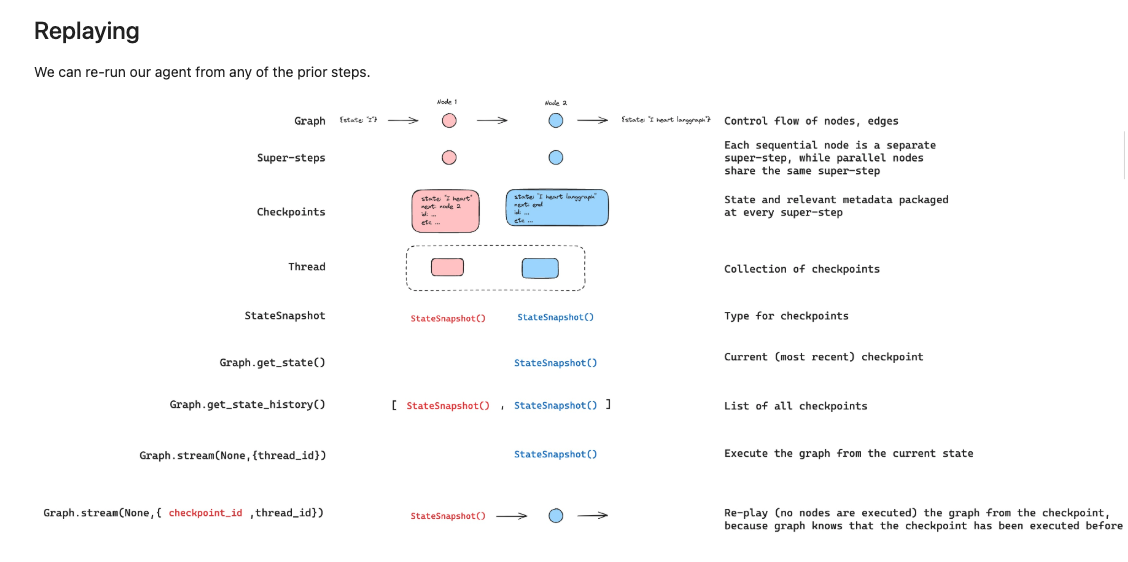

In [58]:
to_replay = all_states[-2]

to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='87a25ef6-75af-4986-95df-7fec728290f6')]}

In [63]:
to_replay.next




('assistant',)

In [64]:
to_replay.config



{'configurable': {'thread_id': '11',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcafb8-0758-67fc-8000-60a5520d517e'}}

In [65]:
for event in graph.stream(None, to_replay.config, stream_mode = "values"):
    event["messages"][-1].pretty_print()
    

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_V2nnEFtV8wN2vypHzSZBgj3M)
 Call ID: call_V2nnEFtV8wN2vypHzSZBgj3M
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


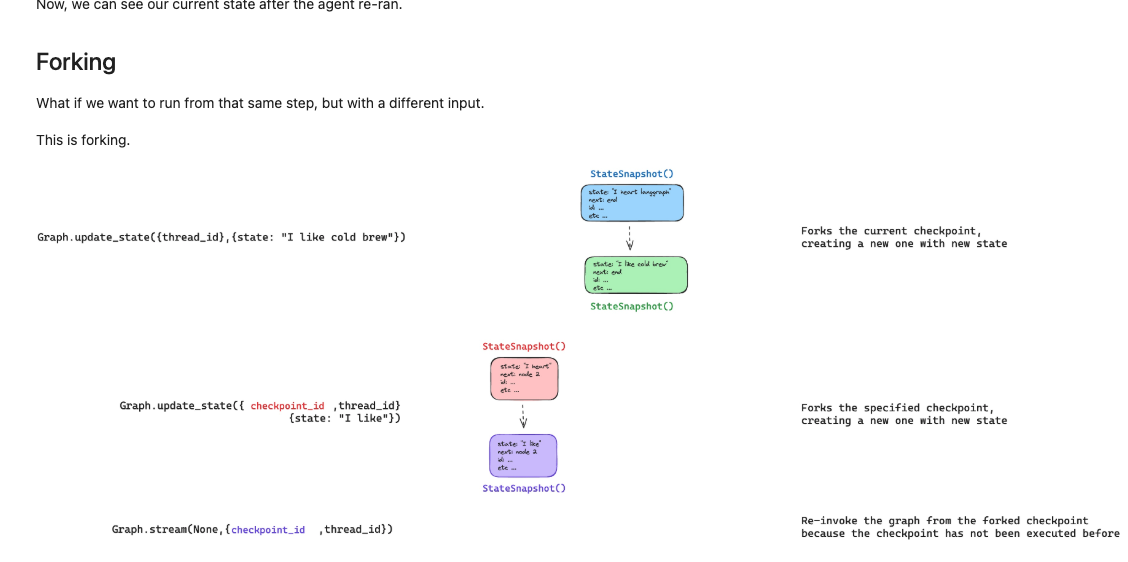

In [73]:
to_fork = all_states[-2]
to_fork.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='87a25ef6-75af-4986-95df-7fec728290f6')]}

In [75]:
to_fork_id = to_fork.values["messages"][0].id
to_fork_id

'87a25ef6-75af-4986-95df-7fec728290f6'

In [68]:

to_fork.config


{'configurable': {'thread_id': '11',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcafb8-0758-67fc-8000-60a5520d517e'}}

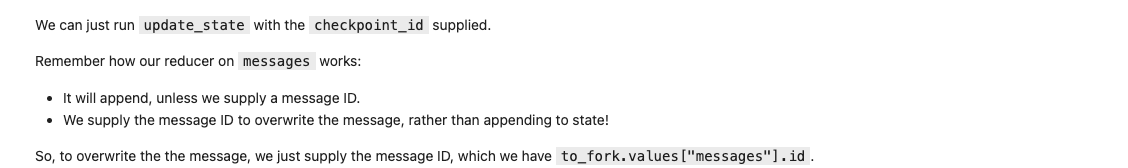

In [77]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages" : [HumanMessage(content = "Multiply 5 and 8", id = to_fork_id)]},
    
)

fork_config



{'configurable': {'thread_id': '11',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcafee-7877-61c8-8001-c9a8c98d16b7'}}

In [78]:
all_states = [state for state in graph.get_state_history({'configurable' : {'thread_id' : '11'}})]


In [80]:
all_states[0].values

{'messages': [HumanMessage(content='Multiply 5 and 8', additional_kwargs={}, response_metadata={}, id='87a25ef6-75af-4986-95df-7fec728290f6')]}

In [81]:
graph.get_state({'configurable' : {'thread_id' : '11'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 8', additional_kwargs={}, response_metadata={}, id='87a25ef6-75af-4986-95df-7fec728290f6')]}, next=('assistant',), config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1efcafee-7877-61c8-8001-c9a8c98d16b7'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 8', additional_kwargs={}, response_metadata={}, id='87a25ef6-75af-4986-95df-7fec728290f6')]}}, 'thread_id': '11', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efcafb8-0758-67fc-8000-60a5520d517e'}, created_at='2025-01-05T00:49:22.669136+00:00', parent_config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1efcafb8-0758-67fc-8000-60a5520d517e'}}, tasks=(PregelTask(id='aaabac4a-f94b-e53c-db76-9a003bf5f000', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [83]:
for event in graph.stream(None, fork_config, stream_mode = "values"):
    event["messages"][-1].pretty_print()
    

================================ Human Message =================================

Multiply 5 and 8
================================== Ai Message ==================================
Tool Calls:
  multiply (call_zx1ax0JIKahA1lMqcGb3FcT0)
 Call ID: call_zx1ax0JIKahA1lMqcGb3FcT0
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: multiply

40
================================== Ai Message ==================================

The result of multiplying 5 and 8 is 40.


In [84]:
all_states = [state for state in graph.get_state_history({'configurable' : {'thread_id' : '11'}})]

In [86]:
for state in all_states:
    print(state.values["messages"])
    for message in state.values["messages"]:
        message.pretty_print()
    print("-"*100)

[HumanMessage(content='Multiply 5 and 8', additional_kwargs={}, response_metadata={}, id='87a25ef6-75af-4986-95df-7fec728290f6'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zx1ax0JIKahA1lMqcGb3FcT0', 'function': {'arguments': '{"a":5,"b":8}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ac62da00-08ec-4fce-9dad-1619450b2d89-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 8}, 'id': 'call_zx1ax0JIKahA1lMqcGb3FcT0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 134, 'output_tokens': 18, 'total_to

In [87]:
len(all_states)

12

## With Langgraph API

In [106]:
from langgraph_sdk import get_client
client = get_client(url ="http://localhost:63909")

initial_input = {"messages" : [HumanMessage(content = "Multiply 2 and 3")]}

thread =  await client.threads.create()

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = initial_input,
    stream_mode = "updates"      
):
    

    assistant_node = chunk.data.get("assistant", {}).get("messages",[])
    tool_node = chunk.data.get("tools", {}).get("messages",[])
    if assistant_node:
        print("--"*20+"Assistant Node"+"--"*20)
        print(assistant_node[-1])
    if tool_node:
        print("--"*20+"Tool Node"+"--"*20)
        print(tool_node[-1])
    print("-"*100)
    


----------------------------------------------------------------------------------------------------
----------------------------------------Assistant Node----------------------------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_1id1j1RU7GoTKpeCi9yUNGhe', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-2bb3cc11-6e51-4c9d-9c34-bd036482531e-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call

In [119]:
from langgraph_sdk import get_client
client = get_client(url ="http://localhost:63909")

initial_input = {"messages" : [HumanMessage(content = "Multiply 2 and 3")]}

thread =  await client.threads.create()

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = initial_input,
    stream_mode = "values"      
):
    

    print(f"Receiving new event of type : {chunk.event}....")
    messages = chunk.data.get("messages",[])
    if messages:
        print(messages[-1])
    print("-"*100)
    

Receiving new event of type : metadata....
----------------------------------------------------------------------------------------------------
Receiving new event of type : values....
{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'be8d9094-606a-4e8e-8ede-81602c020a02', 'example': False}
----------------------------------------------------------------------------------------------------
Receiving new event of type : values....
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_kKitBPaSikh2ZElaNsijaFlS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_t

### Replaying a state

In [129]:
states = await client.threads.get_history(thread["thread_id"])
for state in states:
    print(state["values"]["messages"])
    print("-"*100)


[{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'be8d9094-606a-4e8e-8ede-81602c020a02', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_kKitBPaSikh2ZElaNsijaFlS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-02edac97-216f-4b74-ab49-7f65ae19b9c8-0', 'example': False, 'tool_calls': [{'name': 

In [133]:
states[-2]["values"]["messages"]

[{'content': 'Multiply 2 and 3',
  'additional_kwargs': {'example': False,
   'additional_kwargs': {},
   'response_metadata': {}},
  'response_metadata': {},
  'type': 'human',
  'name': None,
  'id': 'be8d9094-606a-4e8e-8ede-81602c020a02',
  'example': False}]

In [134]:
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {'example': False,
     'additional_kwargs': {},
     'response_metadata': {}},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'be8d9094-606a-4e8e-8ede-81602c020a02',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '41410034-ddc0-0be9-e98d-8e3f5d18775c',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'tool_calls': [{'id': 'call_kKitBPaSikh2ZElaNsijaFlS',
         'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
         'type': 'function'}],
       'refusal': None},
      'response_metadata': {'token_usage': {'completion_tokens': 18,
        'prompt_tokens': 134,
        'total_tokens': 152,
        'completion_tokens_details': {'accepted_prediction_tokens': 0,
         'au

Stream mode -values

In [136]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = initial_input,
    stream_mode = "values"   ,
    checkpoint_id=to_replay["checkpoint_id"]
):
    

    print(f"Receiving new event of type : {chunk.event}....")
    messages = chunk.data.get("messages",[])
    if messages:
        print(messages)
    print("-"*100)
    

Receiving new event of type : metadata....
----------------------------------------------------------------------------------------------------
Receiving new event of type : values....
[{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'be8d9094-606a-4e8e-8ede-81602c020a02', 'example': False}, {'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a7ba6f60-6131-408d-95cd-c6d50342d2a2', 'example': False}]
----------------------------------------------------------------------------------------------------
Receiving new event of type : values....
[{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id'

stream_mode - updates

In [137]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = initial_input,
    stream_mode = "updates"   ,
    checkpoint_id=to_replay["checkpoint_id"]
):
    if chunk.data:
        assistant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assistant_node:
            print("--"*20+"Assistant Node"+"--"*20)
            print(assistant_node[-1])
        if tool_node:
            print("--"*20+"Tool Node"+"--"*20)
            print(tool_node[-1])



----------------------------------------Assistant Node----------------------------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_D0tGYV989jZNC1bFxNU5gQTG', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 144, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-f264fd1a-74c0-4ad5-a3f7-288d27731518-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_D0tGYV989jZNC1bFxNU5gQTG', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'inpu

### Forking a state

In [138]:
initial_input = {"messages" : [HumanMessage(content = "Multiply 2 and 3")]}

thread =  await client.threads.create()

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = initial_input,
    stream_mode = "updates",
    
):
    if chunk.data:
        assistant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assistant_node:
            print("--"*20+"Assistant Node"+"--"*20)
            print(assistant_node[-1])
        if tool_node:
            print("--"*20+"Tool Node"+"--"*20)
            print(tool_node[-1])


----------------------------------------Assistant Node----------------------------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_0MaOZsXPvGrURsi18RlMV4ej', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-bd094454-881c-421b-b205-eac70ef7ac2d-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_0MaOZsXPvGrURsi18RlMV4ej', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'inpu

In [146]:
states = await client.threads.get_history(thread["thread_id"])

to_fork = states[-2]
to_fork["values"]



{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {'example': False,
    'additional_kwargs': {},
    'response_metadata': {}},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': 'a8f01a3b-a329-4c03-a048-f773d2921d68',
   'example': False}]}

In [147]:
to_fork["values"]["messages"][0]["id"]

to_fork_id = to_fork["values"]["messages"][0]["id"]
to_fork_id



'a8f01a3b-a329-4c03-a048-f773d2921d68'

In [149]:
to_fork["checkpoint_id"]

'1efcb0f1-e0bf-6d44-8000-6cced0b363ee'

In [150]:
to_fork["next"]

['assistant']

In [151]:
forked_input = {"messages" : [HumanMessage(content = "Multiply 5 and 8", id = to_fork_id)]}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork["checkpoint_id"]
)
forked_config


{'checkpoint': {'thread_id': '433e630e-84de-4ace-b8fe-3c7c6d9cbd44',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcb0fb-de9b-6666-8001-68a1482fcaaf'},
 'configurable': {'thread_id': '433e630e-84de-4ace-b8fe-3c7c6d9cbd44',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcb0fb-de9b-6666-8001-68a1482fcaaf'},
 'checkpoint_id': '1efcb0fb-de9b-6666-8001-68a1482fcaaf'}

In [152]:
states = await client.threads.get_history(thread["thread_id"])
for state in states:
    print(state["values"]["messages"])
    print("-"*100)


[{'content': 'Multiply 5 and 8', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a8f01a3b-a329-4c03-a048-f773d2921d68', 'example': False}]
----------------------------------------------------------------------------------------------------
[{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a8f01a3b-a329-4c03-a048-f773d2921d68', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_0MaOZsXPvGrURsi18RlMV4ej', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, '

In [153]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = None,
    stream_mode = "updates",
    checkpoint_id=forked_config["checkpoint_id"]
):
    if chunk.data:
        assistant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assistant_node:
            print("--"*20+"Assistant Node"+"--"*20)
            print(assistant_node[-1])
        if tool_node:
            print("--"*20+"Tool Node"+"--"*20)
            print(tool_node[-1])


----------------------------------------Assistant Node----------------------------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_W4Rl8SSkCrTOMaX6nQuFntHq', 'function': {'arguments': '{"a":5,"b":8}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-318e2662-50a5-4ac3-af23-5ad3073c1955-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 5, 'b': 8}, 'id': 'call_W4Rl8SSkCrTOMaX6nQuFntHq', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'inpu